https://github.com/Lextal/SotA-CV/blob/master/content/datasets/pascal_voc_2012_segmentation.md

###**ADE20K**
 - https://github.com/CSAILVision/ADE20K/blob/main/README.md


- 27,574 images (25,574 for training and 2,000 for testing) spanning 365 different scenes.
- 707,868 unique objects from 3,688 categories, along with their WordNet definition and hierarchy.
- 193,238 annotated object parts and parts of parts.
- Polygon annotations with attributes, annotation time, depth ordering.

**Format**

Each folder contains images separated by scene category (same scene categories than the Places Database). For each image, the object and part segmentations are stored in two different png files. All object and part instances are annotated sparately.

For each image there are the following files:
- image_name.jpg  `Input RGB image`.
- image_name_seg.png RGB image with `object segmentation mask`.
- image_name_seg_parts_N.png `Parts segmentation mask`, where N is a number (1,2,3,...) indicating the level in the part hierarchy. N=1- parts of objects. As N can be > 1, parts can consist of parts too.
- `image_name folder` for each image and it contains binary masks for all instances present in an image
- image_name.json `Json file` that has annotations describing the content of each image (describing objects and parts). The function `loadAde20K` provided in official toolkit also parses the content of this file. Each line in the json file contains several columns. (See your written notes)

In [ ]:
!wget -nc http://groups.csail.mit.edu/vision/datasets/ADE20K/toolkit/index_ade20k.pkl

--2024-01-05 13:06:32--  http://groups.csail.mit.edu/vision/datasets/ADE20K/toolkit/index_ade20k.pkl
Resolving groups.csail.mit.edu (groups.csail.mit.edu)... 128.30.2.44
Connecting to groups.csail.mit.edu (groups.csail.mit.edu)|128.30.2.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 817537016 (780M)
Saving to: ‘index_ade20k.pkl’

index_ade20k.pkl    100%[===================>] 779.66M  20.7MB/s    in 39s     

2024-01-05 13:07:12 (20.0 MB/s) - ‘index_ade20k.pkl’ saved [817537016/817537016]



In [ ]:
import requests
from pathlib import Path

mypath = Path(".")

utils_path = mypath / "utils"
file_name = utils_path / "utils_ade20k.py"
if utils_path.is_dir():
    print(f"Utils exists.. Skipping download..")
else:
    print(f"Downloading {file_name}...")
    utils_path.mkdir(exist_ok=True, parents=True)
    with open(file_name, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/CSAILVision/ADE20K/main/utils/utils_ade20k.py")
        f.write(request.content)

Utils exists.. Skipping download..


In [ ]:
!pip install ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.4 MB/s eta 0:00:00


In [ ]:
%load_ext autoreload
%autoreload 2
import IPython.display
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pickle as pkl
from utils import utils_ade20k

DATASET_PATH = "./"
index_file = "index_ade20k.pkl"

with open("{}/{}".format(DATASET_PATH, index_file), "rb") as f:
    index_ade20k = pkl.load(f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
type(index_ade20k)

dict

In [ ]:
index_ade20k.keys()

dict_keys(['filename', 'folder', 'objectIsPart', 'objectPresence', 'objectcounts', 'objectnames', 'proportionClassIsPart', 'scene', 'wordnet_found', 'wordnet_level1', 'wordnet_synset', 'wordnet_hypernym', 'wordnet_gloss', 'wordnet_frequency', 'description'])

In [ ]:
index_ade20k["description"]

{'filename': 'array of length N=27574 with the image file names',
 'folder': 'array of length N with the image folder names.',
 'scene': 'array of length N providing the scene name (same classes as the Places database) for each image.',
 'objectIsPart': 'array of size [C, N] counting how many times an object is a part in each image. objectIsPart[c,i]=m if in image i object class c is a part of another object m times. For objects, objectIsPart[c,i]=0, and for parts we will find: objectIsPart[c,i] = objectPresence(c,i)',
 'objectPresence': 'array of size [C, N] with the object counts per image. objectPresence(c,i)=n if in image i there are n instances of object class c.',
 'objectcounts': 'array of length C with the number of instances for each object class.',
 'objectnames': 'array of length C with the object class names.',
 'proportionClassIsPart': 'array of length C with the proportion of times that class c behaves as a part. If proportionClassIsPart[c]=0 then it means that this is a 

In [ ]:
print("File loaded, description of the attributes:")
print('--------------------------------------------')
for attribute_name, description in index_ade20k["description"].items(): #gives description of each key present in the index_ade20k
    print('* {}: {}'.format(attribute_name, description))
print('--------------------------------------------\n')

File loaded, description of the attributes:
--------------------------------------------
* filename: array of length N=27574 with the image file names
* folder: array of length N with the image folder names.
* scene: array of length N providing the scene name (same classes as the Places database) for each image.
* objectIsPart: array of size [C, N] counting how many times an object is a part in each image. objectIsPart[c,i]=m if in image i object class c is a part of another object m times. For objects, objectIsPart[c,i]=0, and for parts we will find: objectIsPart[c,i] = objectPresence(c,i)
* objectPresence: array of size [C, N] with the object counts per image. objectPresence(c,i)=n if in image i there are n instances of object class c.
* objectcounts: array of length C with the number of instances for each object class.
* objectnames: array of length C with the object class names.
* proportionClassIsPart: array of length C with the proportion of times that class c behaves as a part. 

In [ ]:
#acessing the details of a single image in our index_ade_20k sample data
i = 16868 # 16899, 16964 we have 3 images folders and respective files in our pickle file, each image folder is represented by its name, here the number

nfiles = len(index_ade20k['filename'])
file_name = index_ade20k['filename'][i]
num_obj = index_ade20k['objectPresence'][:, i].sum()
num_parts = index_ade20k['objectIsPart'][:, i].sum()
count_obj = index_ade20k['objectPresence'][:, i].max()
obj_id = np.where(index_ade20k['objectPresence'][:, i] == count_obj)[0][0]
obj_name = index_ade20k['objectnames'][obj_id]
full_file_name = '{}/{}'.format(index_ade20k['folder'][i], index_ade20k['filename'][i])

print("The dataset has {} images".format(nfiles))
print("The image at index {} is {}".format(i, file_name))
print("It is located at {}".format(full_file_name))
print("It happens in a {}".format(index_ade20k['scene'][i]))
print("It has {} objects, of which {} are parts".format(num_obj, num_parts))
print("The most common object is object {} ({}), which appears {} times".format(obj_name, obj_id, count_obj))

The dataset has 27574 images
The image at index 16868 is ADE_train_00016869.jpg
It is located at ADE20K_2021_17_01/images/ADE/training/urban/street/ADE_train_00016869.jpg
It happens in a /street
It has 70.0 objects, of which 19.0 are parts
The most common object is object car, auto, automobile, machine, motorcar (400), which appears 11.0 times


In [ ]:
index_ade20k['objectPresence'].shape #(C, N)

(3688, 27574)

In [ ]:
i = 16868
count_obj = index_ade20k['objectPresence'][:, i].max()
obj_id = np.where(index_ade20k['objectPresence'][:, i] == count_obj)[0][0]

index_ade20k['objectPresence'][:, i], index_ade20k['objectPresence'][:, i].shape, count_obj, np.where(index_ade20k['objectPresence'][:, i] == count_obj)

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 (3688,),
 11.0,
 (array([400]),))

**Loading a segmentation object**

We will visualize the same object we were studying before i.e for image 16868. We can load a segmentation and instance mask for a given image using `utils_ade20k.loadAde20K`.

the dataset has instance annotation masks in the imagefilename_seg.png

In the instance annotation masks, the R(ed) channel encodes category ID, and the G(reen) channel encodes instance ID. Each object instance has a unique instance ID regardless of its category ID. In the dataset, all images have <256 object instances.

In [ ]:
!git clone https://github.com/CSAILVision/ADE20K.git

Cloning into 'ADE20K'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 221 (delta 129), reused 198 (delta 117), pack-reused 0
Receiving objects: 100% (221/221), 5.75 MiB | 9.98 MiB/s, done.
Resolving deltas: 100% (129/129), done.


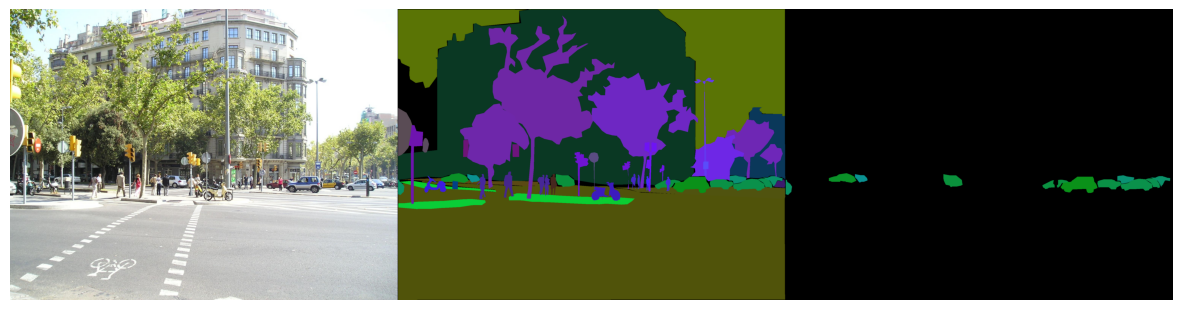

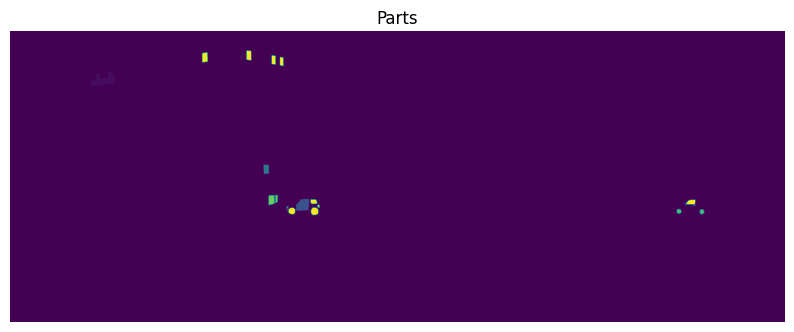

In [ ]:
from pathlib import Path

root_path = Path(DATASET_PATH) / "ADE20K" / "dataset"

# This function reads the image and mask files, and generate instance and segmentation masks
#loadAde20K read the mask file stored as _seg.png and get instance mask and segmentation mask from RGB channels
#Segmentation mask - from R and G channels
#Instance mask - from B channel
#function also returns the segimage, objects segmentation masks, objects instance masks, objects annotation info loaded from respective annotation files that contains class, polygon and other details of the object, and also part level masks
info = utils_ade20k.loadAde20K('{}/{}'.format(root_path, full_file_name)) #full_file_name = ADE20K_2021_17_01/images/ADE/training/urban/street/ADE_train_00016869.jpg
img = cv2.imread(info['img_name'])[:,:,::-1] # orignal image file
seg = cv2.imread(info['segm_name'])[:,:,::-1] # original respective seg file from dataset with instance level annoations from we access channels to get instance and segmentation masks
seg_mask = seg.copy()

# The 0 index in seg_mask corresponds to background (not annotated) pixels
seg_mask[info['class_mask'] != obj_id+1] *= 0 #class mask is nothing but segmentation mask - perpixel category mask
plt.figure(figsize=(15,5))

plt.imshow(np.concatenate([img, seg, seg_mask], 1))
plt.axis('off')
if len(info['partclass_mask']):
    plt.figure(figsize=(5*len(info['partclass_mask']), 5))
    plt.title('Parts')
    plt.imshow(np.concatenate(info['partclass_mask'],1))
    plt.axis('off')

In [ ]:
print(info["class_mask"].shape)
print(info["instance_mask"].shape)
print(np.unique(info["class_mask"]))
print(np.unique(info["instance_mask"]))

(1536, 2048)
(1536, 2048)
[   0   64  312  401  461 1563 1831 2131 2377 2380 2420 2616 2836 2855]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]


You can also inspect the attributes info['objects'] and info['parts'] for information about object names, attributes etc.

In [ ]:
info["objects"]

{'instancendx': array([ 0,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 37,
        38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 51, 52, 53, 66, 67, 68, 69]),
 'class': ['traffic light',
  'traffic light',
  'car',
  'sign',
  'trash can',
  'person',
  'person',
  'building',
  'car',
  'car',
  'sidewalk',
  'central reservation',
  'central reservation',
  'central reservation',
  'car',
  'person',
  'person',
  'person',
  'tree',
  'tree',
  'car',
  'car',
  'car',
  'car',
  'traffic light',
  'sign',
  'sky',
  'building',
  'tree',
  'tree',
  'tree',
  'motorbike',
  'tree',
  'person',
  'person',
  'sign',
  'car',
  'road',
  'road',
  'cars',
  'motorbikes',
  'cars',
  'sign',
  'traffic light',
  'traffic light',
  'street light',
  'person',
  'person',
  'traffic light',
  'traffic light',
  'motorbike'],
 'corrected_raw_name': ['traffic light, traffic signal, stoplight',
  'traffic

**Amodal segmentation and Polygons**

We also provide access to the original polygons annotated, as well as the amodal segmentation of object instances

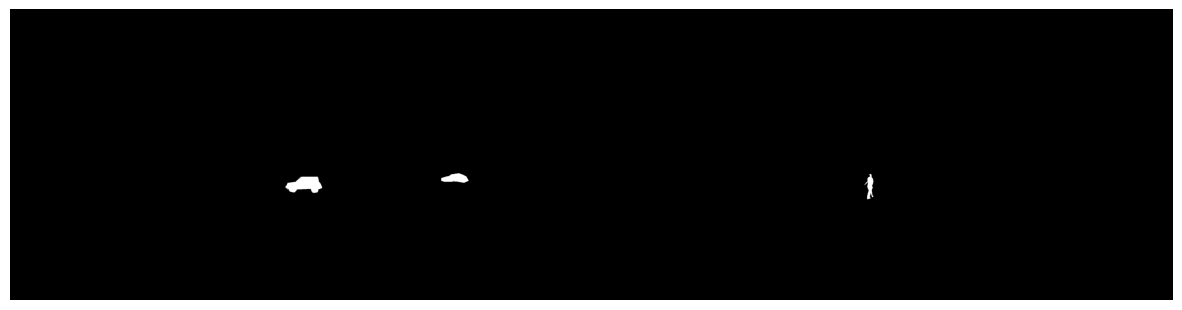

In [ ]:
# We have a segmentation for every object instance, showing object bounds without occlusions
instances = [4, 10, 19]
images = []
for instance in instances:
    file_instance = '{}/{}/instance_{:03}_{}'.format(
        root_path, full_file_name.replace('.jpg', ''), instance, file_name.replace('.jpg', '.png'))
    aux = cv2.imread(file_instance)
    images.append(aux)
plt.figure(figsize=(5*len(images), 5))
plt.imshow(np.concatenate(images, 1))
plt.axis('off')
plt.show()

(-0.5, 2047.5, 1535.5, -0.5)

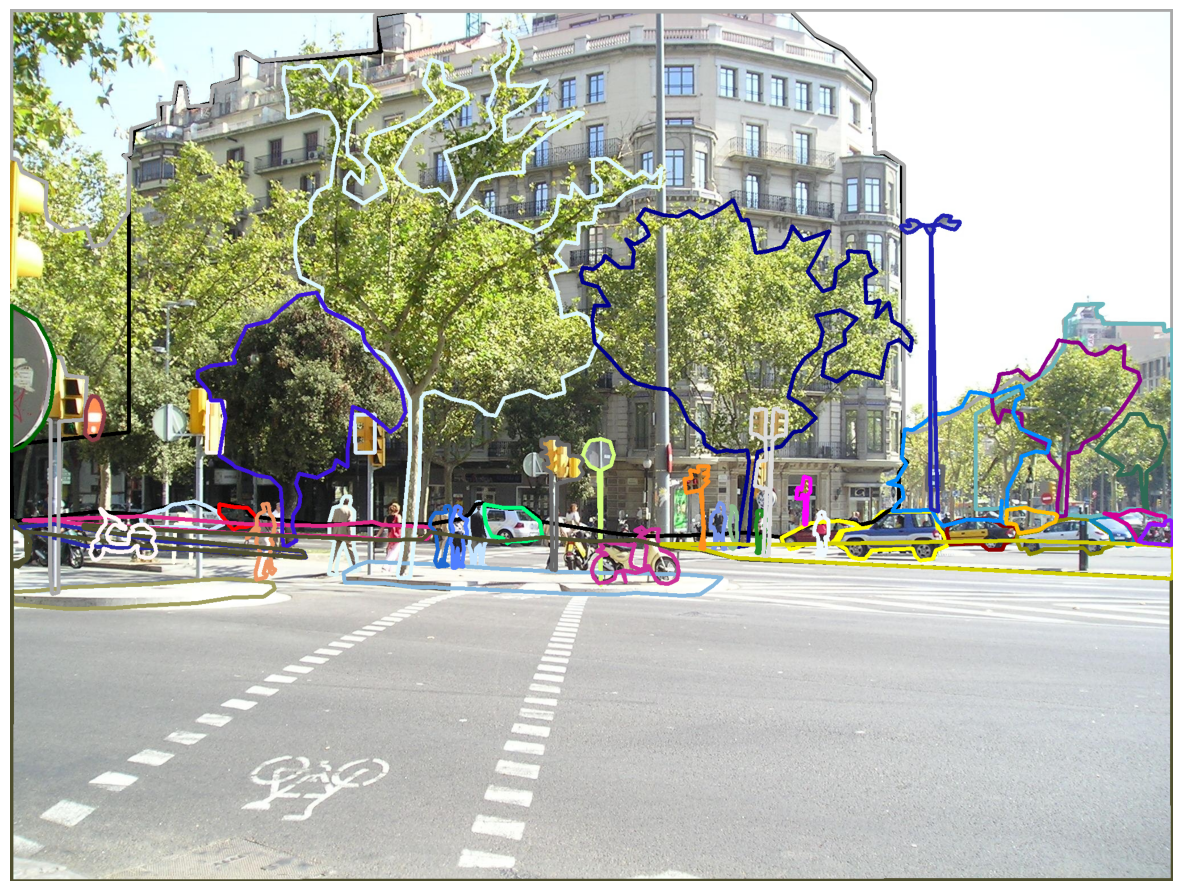

In [ ]:
#Finally we can get the original polygons

img = utils_ade20k.plot_polygon('{}/{}'.format(root_path, full_file_name), info)
plt.figure(figsize=(15,15))
plt.imshow(img[:, :, ::-1])
plt.axis('off')

###**COCO**

- Train set: ~83000 images, 604907 instances
- Validation set: ~41000 images
- 80 classes joined into 12 supercategories
- Number of pixels: 90% of images have between 167500 and 355840 pixels in train set.
- Height/width ratio: 90% of images have the ration between 0.6 and 1.5 in train set.
- Number of instances: 99% of images contain between 1 and 33 different instances, median = 4 (train set).

We can use pycocotools api to play with data from annotations file

It also provides coco evaluator

The challenge uses several metrics, but among typically reported are:

- Mean Average Precision
- Average Precision @ 0.5, 0.75 IoU for labels on bounding - boxes having >= 0.5 IoU with ground truth — primary metric.
- AP-small — AP for instances with areas (total pixels) < 1024
- AP-medium — AP for instances with 1024 <= area < 9216
- AP-large — AP for instances with area >= 9216

https://cocodataset.org/#download

https://machinelearningspace.com/coco-dataset-a-step-by-step-guide-to-loading-and-visualizing/

https://towardsdatascience.com/master-the-coco-dataset-for-semantic-image-segmentation-part-1-of-2-732712631047


COCO has several annotation types:
- object detection / instance segmentation
    - https://cocodataset.org/#detection-2020
- keypoint detection
- stuff segmentation
    - https://cocodataset.org/#stuff-2019
- panoptic segmentation
    - https://cocodataset.org/#panoptic-2019
- densepose
- image captioning

The annotations are stored using JSON. Please note that the COCO API described on the download page can be used to access and manipulate all anotations. All annotations share the same basic data structure.

Ref: https://cocodataset.org/#format-data

Below we are dealing with object detection format.

The COCO object detection train, validation, and test sets, containing more than 200,000 images and 80 object categories. All object instances are annotated with a detailed segmentation mask. Annotations on the training and validation sets (with over 500,000 object instances segmented) are publicly available. The detection task addresses thing classes (person, car, elephant), the stuff task focuses on stuff classes (grass, wall, sky) and the panoptic task addresses both simultaneously.

In [ ]:
#%%bash
#run everything in a cell
#mkdir coco
#cd coco
#mkdir images
#cd images
#wget -c http://images.cocodataset.org/annotations/annotations_trainval2017.zip
#wget -c http://images.cocodataset.org/annotations/panoptic_annotations_trainval2017.zip
#wget -c http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
#wget -c http://images.cocodataset.org/annotations/image_info_test2017.zip
#run any one annotation as you needed.

#wget -c http://images.cocodataset.org/zips/train2017.zip
#wget -c http://images.cocodataset.org/zips/val2017.zip
#wget -c http://images.cocodataset.org/zips/test2017.zip

#unzip train2017.zip
#unzip val2017.zip
#unzip test2017.zip

#rm train2017.zip
#rm val2017.zip
#rm test2017.zip

#cd ../
#mkdir annotations
#cd annotations
#unzip annotations_trainval2017.zip
#unzip stuff_annotations_trainval2017.zip
#unzip image_info_test2017.zip

#rm annotations_trainval2017.zip
#rm stuff_annotations_trainval2017.zip
#rm image_info_test2017.zip

#cd content

We can run in separate shells to avoid download issues

In [ ]:
# rm -rf coco

In [ ]:
!pwd

/content


In [ ]:
from pathlib import Path
path = Path("./coco")
path.mkdir(exist_ok=True, parents=True)
images_path = path / "images"

if not images_path.is_dir():
    print(f"Creating {images_path}")
    images_path.mkdir()
else:
    print(f"{images_path} already exists.. Skipping Creation")

Creating coco/images


In [ ]:
images_path

PosixPath('coco/images')

In [ ]:
#%cd coco/images

# !wget -c http://images.cocodataset.org/zips/train2017.zip

In [ ]:
%cd coco/images
!wget -c http://images.cocodataset.org/zips/val2017.zip
# !wget -c http://images.cocodataset.org/zips/test2017.zip

/content/coco/images
--2024-01-06 14:02:16--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.104.177, 52.216.62.169, 52.216.134.243, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.104.177|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  88.3MB/s    in 11s     

2024-01-06 14:02:27 (71.5 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [ ]:
# !unzip train2017.zip
!unzip val2017.zip
# !unzip test2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000212226.jpg  
 extracting: val2017/000000231527.jpg  
 extracting: val2017/000000578922.jpg  
 extracting: val2017/000000062808.jpg  
 extracting: val2017/000000119038.jpg  
 extracting: val2017/000000114871.jpg  
 extracting: val2017/000000463918.jpg  
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/00000011

In [ ]:
# !rm train2017.zip
!rm val2017.zip
# !rm test2017.zip

%cd ../..

/content


In [ ]:
%cd coco

!wget -c http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!wget -c http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
!wget -c http://images.cocodataset.org/annotations/panoptic_annotations_trainval2017.zip
# !wget -c http://images.cocodataset.org/annotations/image_info_test2017.zip

!unzip annotations_trainval2017.zip
!unzip stuff_annotations_trainval2017.zip
!unzip panoptic_annotations_trainval2017.zip
# !unzip image_info_test2017.zip

!rm annotations_trainval2017.zip
!rm stuff_annotations_trainval2017.zip
!rm panoptic_annotations_trainval2017.zip
# !rm image_info_test2017.zip

%cd content

[Errno 2] No such file or directory: 'coco'
/content/coco
--2024-01-06 15:22:22--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.64.25, 52.216.207.147, 3.5.29.111, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.64.25|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  75.9MB/s    in 3.2s    

2024-01-06 15:22:25 (75.9 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

--2024-01-06 15:22:25--  http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.171.185, 52.217.132.89, 16.182.108.161, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.171.185|:80... connected.
HTTP request sent, awaiting r

In [ ]:
pwd

'/content/coco'

In [ ]:
#lets vosualize whats there in thes each annotation files
import json
with open("/content/coco/annotations/instances_val2017.json", "r") as f:
    instances_val_json = json.load(f)

instances_val_json.keys(), instances_val_json["categories"][0], len(instances_val_json["annotations"]), instances_val_json["annotations"][0].keys(), instances_val_json["annotations"][0]["segmentation"]

(dict_keys(['info', 'licenses', 'images', 'annotations', 'categories']),
 {'supercategory': 'person', 'id': 1, 'name': 'person'},
 36781,
 dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id']),
 [[510.66,
   423.01,
   511.72,
   420.03,
   510.45,
   416.0,
   510.34,
   413.02,
   510.77,
   410.26,
   510.77,
   407.5,
   510.34,
   405.16,
   511.51,
   402.83,
   511.41,
   400.49,
   510.24,
   398.16,
   509.39,
   397.31,
   504.61,
   399.22,
   502.17,
   399.64,
   500.89,
   401.66,
   500.47,
   402.08,
   499.09,
   401.87,
   495.79,
   401.98,
   490.59,
   401.77,
   488.79,
   401.77,
   485.39,
   398.58,
   483.9,
   397.31,
   481.56,
   396.35,
   478.48,
   395.93,
   476.68,
   396.03,
   475.4,
   396.77,
   473.92,
   398.79,
   473.28,
   399.96,
   473.49,
   401.87,
   474.56,
   403.47,
   473.07,
   405.59,
   473.39,
   407.71,
   476.68,
   409.41,
   479.23,
   409.73,
   481.56,
   410.69,
   480.4,
   411.85,
   481.

In [ ]:
import json
with open("/content/coco/annotations/stuff_val2017.json", "r") as f:
    stuff_val_json = json.load(f)

stuff_val_json.keys(), stuff_val_json["categories"][0], len(stuff_val_json["annotations"]), stuff_val_json["annotations"][0].keys(), stuff_val_json["annotations"][0]["segmentation"]

(dict_keys(['info', 'images', 'licenses', 'categories', 'annotations']),
 {'supercategory': 'textile', 'id': 92, 'name': 'banner'},
 32801,
 dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id']),
 {'counts': 'j19[6h1ZNXNf1h1ZNYNe1g1[NYNf1f1YNZNh1e1YN^Nd1b1ZNbNd1^1ZNdNf1\\1ZNdNf1\\1ZNdNlKLo4_1UOBj0>kNNRLUNi4l1UO0RLUNh4k1UO;l0DTO<R1^OnNb0R1^OnNc0T1ZOlNg0X1TOhNm0V1SOkNm0T1TOlNl0T1TOjNbNmKZ2X5UOkNm0V1ROkNm0T1TOlNk0U1UOlNj0T1UOmNk0S1UOmNk0S1UOmNk0S1UOmNl0R1TOoNk0l0gMmJ01^1W4j0j0kMoJ[1W4j0j0kMoJ[1X4i0a0UNVKQ1Z4j0`0D@<`0D@<`0D@<`0D@<`0D@<`0D@=?CA=?BB>=CC==CB>:FF:?A@`0a0_O_Oa0b0^O_Ob0`0^O_Oc0a0]O@b0`0]OCa0<@D`0;AE?:BG=8DI;7EI<6DK;1I06OJ35MK35MK35MK35MK35MK45KK55KK55KK55KK64JK75IK75IK75IK75IK75IK84HL85GJ:6FJ:6FJ;5EK;5EK;5EK;5EK;5EK:7EI;7EH;9EG::FF9;GE9;GE9;GE9<EE:<FD:<FC;=EC=;CE=;CE<<DD<<DD=;CE=<BD?WNWKM5k1U41P1JPO6P1JoN7Q1IoN7Q1IoN7R1HnN8Q1JnN5S1KmN5S1KmN5S1KmN5T1JlN6T1JlN6T1JlN6S1KlN6P1SNkJg1U45n0WNmJe1T44o0XNlJd1U44o0XNkJe1V43o03QOMm0TNmJo1V4Mj08VOHi0:VOFk09

In [ ]:
import json
with open("/content/coco/annotations/panoptic_val2017.json", "r") as f:
    panoptic_val_json = json.load(f)

panoptic_val_json.keys(), panoptic_val_json["categories"][0], len(panoptic_val_json["annotations"]), panoptic_val_json["annotations"][0].keys(), panoptic_val_json["annotations"][0]["segments_info"]

(dict_keys(['info', 'licenses', 'images', 'annotations', 'categories']),
 {'supercategory': 'person', 'isthing': 1, 'id': 1, 'name': 'person'},
 5000,
 dict_keys(['segments_info', 'file_name', 'image_id']),
 [{'id': 3226956,
   'category_id': 1,
   'iscrowd': 0,
   'bbox': [413, 158, 53, 138],
   'area': 2840},
  {'id': 6979964,
   'category_id': 1,
   'iscrowd': 0,
   'bbox': [384, 172, 16, 36],
   'area': 439},
  {'id': 3103374,
   'category_id': 62,
   'iscrowd': 0,
   'bbox': [413, 223, 30, 81],
   'area': 1250},
  {'id': 2831194,
   'category_id': 62,
   'iscrowd': 0,
   'bbox': [291, 218, 62, 98],
   'area': 1848},
  {'id': 3496593,
   'category_id': 62,
   'iscrowd': 0,
   'bbox': [412, 219, 10, 13],
   'area': 90},
  {'id': 2633066,
   'category_id': 62,
   'iscrowd': 0,
   'bbox': [317, 219, 22, 12],
   'area': 212},
  {'id': 3165572,
   'category_id': 62,
   'iscrowd': 0,
   'bbox': [359, 218, 56, 103],
   'area': 2251},
  {'id': 8824489,
   'category_id': 64,
   'iscrowd': 0

In [ ]:
!pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI
# !pip install git+https://github.com/cocodataset/panopticapi.git#subdirectory=PythonAPI
# !pip install git+https://github.com/nightrome/cocostuffapi.git#subdirectory=PythonAPI

  Cloning https://github.com/philferriere/cocoapi.git to /tmp/pip-req-build-q0l497h4
  Running command git clone --filter=blob:none --quiet https://github.com/philferriere/cocoapi.git /tmp/pip-req-build-q0l497h4
  Resolved https://github.com/philferriere/cocoapi.git to commit 2929bd2ef6b451054755dfd7ceb09278f935f7ad
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=375463 sha256=654fb4715ec3cba8ccba1a178e22290a617ffbea13fb82229a020bf84a193040
  Stored in directory: /tmp/pip-ephem-wheel-cache-j3_n9gzl/wheels/8e/1a/5f/0c984ae3d65a4d7da4ba3407d2a8d8c8e85dd55f84d4936f04
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.7
    Uninstalling pycocotools-2.0.7:
      Successfully uninstalled pycocotools-2.0.7


In [ ]:
import pycocotools
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import skimage.io as io
import cv2
import matplotlib.gridspec as gridspec
from pathlib import Path
%matplotlib inline

**Dataset Exploration with PyCoco**

First, let’s initiate the PyCoco library. This library takes the COCO annotations (.json) file as an input. Either train or val instances annotations should work, but for this tutorial, I am using “instances_val.json” since it’s faster to load (reason: val dataset is smaller than train dataset).

In [ ]:
#Lets visualize how actually our annotations are like
import json

datadir = "/content/coco"
datatype = f"val"
ann_File = f"{datadir}/annotations/instances_{datatype}2017.json"

with open(f"{datadir}/annotations/instances_{datatype}2017.json", "rb") as f:
    annotation_file = json.load(f)

In [ ]:
annotation_file.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [ ]:
annotation_file["info"]

{'description': 'COCO 2017 Dataset',
 'url': 'http://cocodataset.org',
 'version': '1.0',
 'year': 2017,
 'contributor': 'COCO Consortium',
 'date_created': '2017/09/01'}

In [ ]:
annotation_file["licenses"]

[{'url': 'http://creativecommons.org/licenses/by-nc-sa/2.0/',
  'id': 1,
  'name': 'Attribution-NonCommercial-ShareAlike License'},
 {'url': 'http://creativecommons.org/licenses/by-nc/2.0/',
  'id': 2,
  'name': 'Attribution-NonCommercial License'},
 {'url': 'http://creativecommons.org/licenses/by-nc-nd/2.0/',
  'id': 3,
  'name': 'Attribution-NonCommercial-NoDerivs License'},
 {'url': 'http://creativecommons.org/licenses/by/2.0/',
  'id': 4,
  'name': 'Attribution License'},
 {'url': 'http://creativecommons.org/licenses/by-sa/2.0/',
  'id': 5,
  'name': 'Attribution-ShareAlike License'},
 {'url': 'http://creativecommons.org/licenses/by-nd/2.0/',
  'id': 6,
  'name': 'Attribution-NoDerivs License'},
 {'url': 'http://flickr.com/commons/usage/',
  'id': 7,
  'name': 'No known copyright restrictions'},
 {'url': 'http://www.usa.gov/copyright.shtml',
  'id': 8,
  'name': 'United States Government Work'}]

In [ ]:
type(annotation_file["images"]), len(annotation_file["images"]), annotation_file["images"][0].keys(), annotation_file["images"][:2]

(list,
 5000,
 dict_keys(['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'id']),
 [{'license': 4,
   'file_name': '000000397133.jpg',
   'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg',
   'height': 427,
   'width': 640,
   'date_captured': '2013-11-14 17:02:52',
   'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg',
   'id': 397133},
  {'license': 1,
   'file_name': '000000037777.jpg',
   'coco_url': 'http://images.cocodataset.org/val2017/000000037777.jpg',
   'height': 230,
   'width': 352,
   'date_captured': '2013-11-14 20:55:31',
   'flickr_url': 'http://farm9.staticflickr.com/8429/7839199426_f6d48aa585_z.jpg',
   'id': 37777}])

In [ ]:
type(annotation_file["annotations"]), len(annotation_file["annotations"]), annotation_file["annotations"][0].keys(), annotation_file["annotations"][0]

(list,
 36781,
 dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id']),
 {'segmentation': [[510.66,
    423.01,
    511.72,
    420.03,
    510.45,
    416.0,
    510.34,
    413.02,
    510.77,
    410.26,
    510.77,
    407.5,
    510.34,
    405.16,
    511.51,
    402.83,
    511.41,
    400.49,
    510.24,
    398.16,
    509.39,
    397.31,
    504.61,
    399.22,
    502.17,
    399.64,
    500.89,
    401.66,
    500.47,
    402.08,
    499.09,
    401.87,
    495.79,
    401.98,
    490.59,
    401.77,
    488.79,
    401.77,
    485.39,
    398.58,
    483.9,
    397.31,
    481.56,
    396.35,
    478.48,
    395.93,
    476.68,
    396.03,
    475.4,
    396.77,
    473.92,
    398.79,
    473.28,
    399.96,
    473.49,
    401.87,
    474.56,
    403.47,
    473.07,
    405.59,
    473.39,
    407.71,
    476.68,
    409.41,
    479.23,
    409.73,
    481.56,
    410.69,
    480.4,
    411.85,
    481.35,
    414.93,
    479.86,
    418.

In [ ]:
type(annotation_file["categories"]), len(annotation_file["categories"]), annotation_file["categories"][0].keys(), annotation_file["categories"][0]

(list,
 80,
 dict_keys(['supercategory', 'id', 'name']),
 {'supercategory': 'person', 'id': 1, 'name': 'person'})

In [ ]:
datadir = "/content/coco"
datatype = f"val"
ann_File = f"{datadir}/annotations/instances_{datatype}2017.json"

## Initialize the COCO api object for instance annotations
coco = COCO(annotation_file=ann_File)

loading annotations into memory...
Done (t=1.08s)
creating index...
index created!


In [ ]:
type(coco.anns)

dict

In [ ]:
# Load the categories in a variable
category_ids = coco.getCatIds()
cats = coco.loadCats(ids=category_ids) #The output, i.e. the categories are printed as:
category_ids, cats

([1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  27,
  28,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  67,
  70,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  84,
  85,
  86,
  87,
  88,
  89,
  90],
 [{'supercategory': 'person', 'id': 1, 'name': 'person'},
  {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
  {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
  {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
  {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
  {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
  {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
  {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
  {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 

The COCO dataset has 81 object categories (note that ‘id’:0 is background), as we printed out above (also listed here). However as you can observe, the label ids for these 81 classes range from 0 to 90 (some empty id numbers in between). Here is a convenient function which can fetch a class name for a given id number.

In [ ]:
def getClassName(class_ID, cats):
    for i in range(len(cats)):
        if cats[i]["id"] == class_ID:
            class_name = cats[i]["name"]
            return class_name
    return "None"

print('The class name is', getClassName(77, cats))

The class name is cell phone


**Class Filtering**

Let’s say I want images containing only the classes “laptop”, “tv”, and “cell phone” and I don’t require any other object class. To get this subset of the dataset, follow the steps below:

Number of images containing classes ['laptop', 'tv', 'cell phone'] are: 11


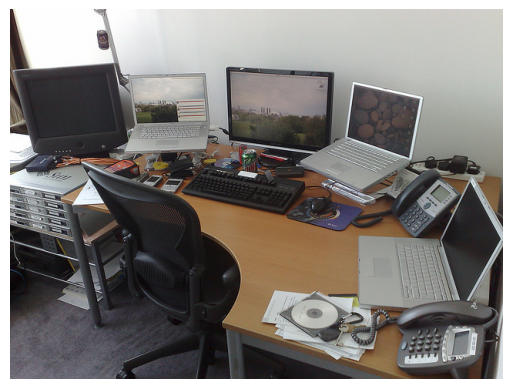

([72, 73, 77],
 [{'supercategory': 'electronic', 'id': 72, 'name': 'tv'},
  {'supercategory': 'electronic', 'id': 73, 'name': 'laptop'},
  {'supercategory': 'electronic', 'id': 77, 'name': 'cell phone'}],
 [160556,
  301421,
  46031,
  316015,
  172595,
  516916,
  465718,
  507575,
  226171,
  225757,
  340894],
 [{'license': 3,
   'file_name': '000000516916.jpg',
   'coco_url': 'http://images.cocodataset.org/val2017/000000516916.jpg',
   'height': 480,
   'width': 640,
   'date_captured': '2013-11-21 02:32:18',
   'flickr_url': 'http://farm2.staticflickr.com/1242/1335331416_3313afb670_z.jpg',
   'id': 516916}])

In [ ]:
# Define the classes (out of the 81) which you want to see. Others will not be shown.
filterClasses = ["laptop", "tv", "cell phone"]

# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses)
cats = coco.loadCats(ids=catIds)

# Get all images containing the above Category IDs
imgIds = coco.getImgIds(catIds=catIds)
print(f"Number of images containing classes {filterClasses} are: {len(imgIds)}")

# load and display a random image
rand_idx = np.random.randint(low=0, high=len(imgIds))
img = coco.loadImgs(ids=imgIds[rand_idx])
#read the image from the url present in img list[dict]
#I = io.imread(fname="http://images.cocodataset.org/val2017/000000226171.jpg) / 255 #from url

I = io.imread(fname=f"{datadir}/images/{datatype}2017/{img[0]['file_name']}") / 255 ##from local file path if images are downloaded

plt.imshow(I)
plt.axis("off")
plt.show()

catIds, cats, imgIds, img

Now, the imgIDs variable contains all the images which contain all the filterClasses. This implies, out of the entire validation dataset, there are 11 images which contain ALL the 3 classes which I wanted. And a sample image displayed is:

To display the annotations we shall follow the code as below. Note that we use pycoco functionalities `loadAnns` to load the annotations concerning the `object` in COCO format and `showAnns` to sketch these out on the image.

These functions largely ease the drawing of the `annotation masks`. You can have a look at the linked function definitions to see how they work internally.

([31950, 36137, 325251, 326319, 1098358, 1102981, 1103789],
 7,
 dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id']))

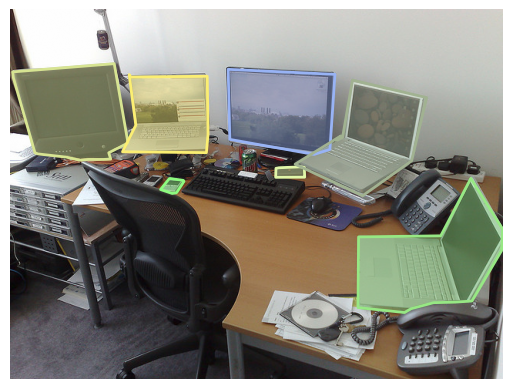

In [ ]:
#get the annotation ids
annIds = coco.getAnnIds(imgIds=img[0]["id"], catIds=catIds, iscrowd=None)
annotations = coco.loadAnns(ids=annIds)

plt.imshow(I)
plt.axis("off")
coco.showAnns(anns=annotations)

annIds, len(annotations), annotations[0].keys()

**All Possible Combinations**

When we filter the dataset with classes, the pycoco tool returns images which consist of only ALL your required classes, not the images with just one or two or any other combinations.

Thus, this piece of code will ensure that all possible combinations for the given filterClass lists are obtained in the resultant dataset.

In [ ]:
# imgIds = coco.getImgIds()
# type(imgIds), len(imgIds)

In [ ]:
classes = ['laptop', 'tv', 'cell phone']

images = []
if classes is not None:
    # iterate for each individual class in the list
    for class_name in classes:
        # get all images containing given class
        catIds = coco.getCatIds(catNms=class_name)
        cats = coco.loadCats(ids=catIds)
        imgIds = coco.getImgIds(catIds=catIds)
        images += coco.loadImgs(ids=imgIds)
else:
    imgIds = coco.getImgIds()
    images = coco.loadImgs(imgIds)

# Now, filter out the repeated images
unique_images = []
for i in range(len(images)):
    if images[i] not in unique_images:
        unique_images.append(images[i])

dataset_size = len(unique_images)
print("Number of images containing the filter classes:", dataset_size)

Number of images containing the filter classes: 503


See how above, we had received only 11 images, but now there are 503 images as we have filtered all the images that have atleast one classs from our filterClasses! We have avoided any repetition of images as well.

**4. Image Segmentation Mask Generation**

For any Semantic Segmentation training task, you’ll require a folder full of the images (train and val) and the corresponding output ground-truth masks. This section will help create the corresponding image masks from the annotations that we have for our COCO dataset.

**Mask Type 1: Normal Semantic Segmentation Mask**

Each pixel has a label according to the class it falls into. I am not using the official COCO class ids, but instead allotting pixel values as per the order of the class name in the array ‘filterClasses’, i.e.:

- 0: background
- 1: laptop
- 2: tv
- 3: cell phone

So, each pixel will be labeled as any of these four class ids

loading annotations into memory...
Done (t=1.07s)
creating index...
index created!


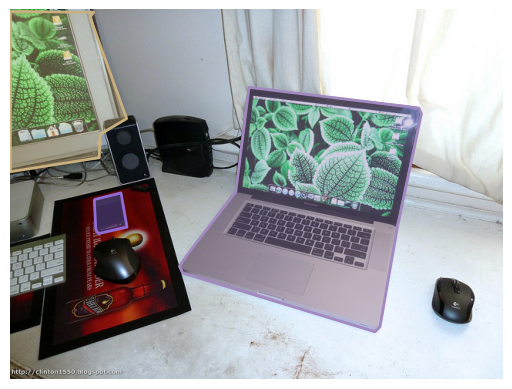

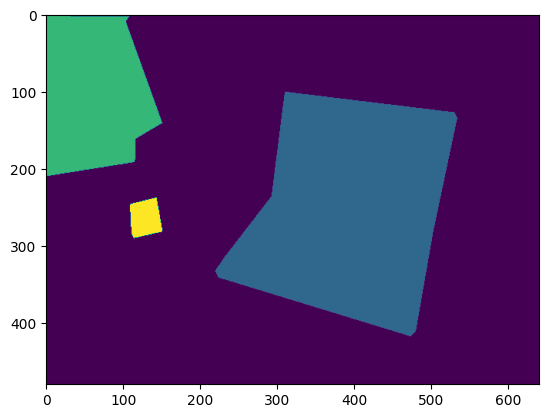

In [ ]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
%matplotlib inline

datadir = "/content/coco/"
datatype = "val2017"
annFile = f"{datadir}annotations/instances_{datatype}.json"
coco = COCO(annotation_file=annFile)

filterClasses = ["laptop", "tv", "cell phone"]

catIds = coco.getCatIds(catNms=filterClasses)
cats = coco.loadCats(ids=catIds)

imgIds = coco.getImgIds(catIds=catIds)
img = coco.loadImgs(ids=imgIds[np.random.randint(0, len(imgIds))])[0]

annIds = coco.getAnnIds(catIds=catIds, imgIds=img["id"], iscrowd=None)
anns = coco.loadAnns(ids=annIds)

def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]["id"] == classID:
            class_name = cats[i]["name"]
            return class_name
    return "None"

#plot original image with segmentation on it
I = io.imread(f"{datadir}images/{datatype}/{img['file_name']}")  / 255.
plt.imshow(I)
plt.axis("off")
coco.showAnns(anns=anns)
plt.show()

#Generate ground truth mask from the segmentaion annotations
mask = np.zeros((img["height"], img["width"]))
for i in range(len(anns)):
    class_name = getClassName(anns[i]["category_id"], cats)
    pixel_label = filterClasses.index(class_name) + 1 #+1 bcuz we also have bg as 0 index and didnt include in the filterClasses
    ann = anns[i]
    # print(np.unique(coco.annToMask(ann=ann))) #0, 1
    # print((coco.annToMask(ann=ann) * pixel_label).shape) #(480, 640)
    #mask = coco.annToMask(ann=ann) * pixel_label
    mask = np.maximum(coco.annToMask(ann=ann) * pixel_label, mask)

plt.imshow(mask)
plt.show()

In [ ]:
mask.shape, np.unique(mask)

((480, 640), array([0., 1., 2., 3.]))

**Mask Type 2: Binary Semantic Segmentation Mask**

In general, your output mask will have N possible pixel values for N output classes. However, binary masking implies that the output mask will have only 2 pixel values, i.e., 1 (object: could be any of the N classes) and 0 (the background).

Note: This means, all the pixel values will be labeled as either 0 or 1. The shape will be same as images shape. No extra channels. It is different from N channeled  binary masks each belonging to one class in N.

loading annotations into memory...
Done (t=1.49s)
creating index...
index created!


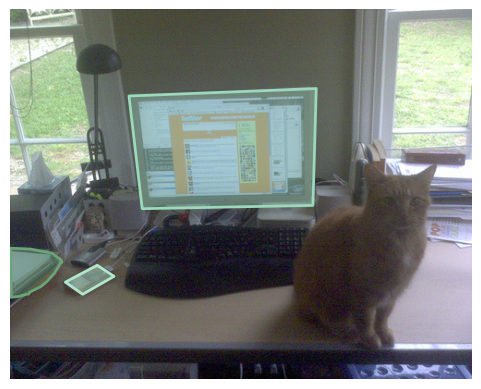

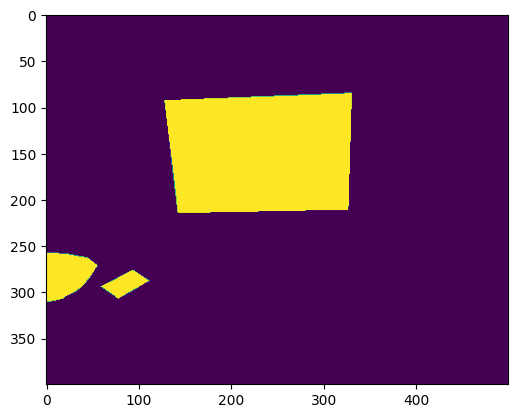

In [ ]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
%matplotlib inline

datadir = "/content/coco/"
datatype = "val2017"
annFile = f"{datadir}annotations/instances_{datatype}.json"
coco = COCO(annotation_file=annFile)

filterClasses = ["laptop", "tv", "cell phone"]

catIds = coco.getCatIds(catNms=filterClasses)
cats = coco.loadCats(ids=catIds)

imgIds = coco.getImgIds(catIds=catIds)
img = coco.loadImgs(ids=imgIds[np.random.randint(0, len(imgIds))])[0]

annIds = coco.getAnnIds(catIds=catIds, imgIds=img["id"], iscrowd=None)
anns = coco.loadAnns(ids=annIds)

def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]["id"] == classID:
            class_name = cats[i]["name"]
            return class_name
    return "None"

#plot original image with segmentation on it
I = io.imread(f"{datadir}images/{datatype}/{img['file_name']}")  / 255.
plt.imshow(I)
plt.axis("off")
coco.showAnns(anns=anns)
plt.show()

#Generate ground truth mask from the segmentaion annotations
mask = np.zeros((img["height"], img["width"]))
for i in range(len(anns)):
    ann = anns[i]
    mask = np.maximum(coco.annToMask(ann=ann), mask)

plt.imshow(mask)
plt.show()

In [ ]:
(img["height"], img["width"]), mask.shape, np.unique(mask)

((400, 500), (400, 500), array([0., 1.]))

Note: the format of how your desired masks can be different from the ones mentioned above. For example, you might want to keep the label id numbers the same as in the original COCO dataset (0–90). Or you might want an output format for an instance segmentation use case.

Another example is, you might want your masks to be one-hot-encoded, i.e., number of channels = number of output object classes, and each channel having only 0s (background) and 1s (that object).

For any case, modify the above code accordingly and you can get the mask as you desire. If I get some time in the future, I’ll try to add the codes for these additional types as well.

###**CityScapes**

https://www.cityscapes-dataset.com/dataset-overview/

https://www.xilinx.com/developer/articles/part2-prepare-the-cityscapes-database-for-training-segmentation-models.html

https://huggingface.co/spaces/CVPR/regionclip-demo/blame/b654e12a431c042e51667d2d40ca2a1c957f411b/detectron2/data/datasets/cityscapes.py

https://datasetninja.com/cityscapes

https://github.com/mcordts/cityscapesScripts/tree/master

https://medium.com/@mhamdaan/multi-class-semantic-segmentation-with-u-net-pytorch-ee81a66bba89

https://github.com/hamdaan19/UNet-Multiclass/blob/main/scripts/datasets.py

Cityscapes (5000 Images) is a dataset for instance segmentation, object detection, and semantic segmentation tasks. It is used in the automotive industry.

The dataset consists of `5000 images with 287540 labeled objects belonging to 40 different classes` including ```ego vehicle, out of roi, static, and other: pole, building, road, vegetation, car, sidewalk, traffic sign, sky, person, license plate, terrain, traffic light, bicycle, rectification border, dynamic, fence, ground, rider, wall, cargroup, parking, bicyclegroup, motorcycle, persongroup, truck, bus, polegroup, bridge, train, rail track, trailer, caravan, tunnel, guard rail, ridergroup, motorcyclegroup, and truckgroup```.

Images in the Cityscapes dataset have ```pixel-level instance segmentation annotations```. Due to the nature of the instance segmentation task, it can be automatically transformed into a semantic segmentation (only one mask for every class) or object detection (bounding boxes for every object) tasks.

All images are labeled (i.e. with annotations).

There are 3 splits in the dataset:
- train (2975 images)
- test (1525 images)
- val (500 images).

Alternatively, the dataset could be split into 27 cities:
```berlin (544 images), munich (398 images), strasbourg (365 images), bremen (316 images), mainz (298 images), frankfurt (267 images), hamburg (248 images), dusseldorf (221 images), hanover (196 images), stuttgart (196 images), bielefeld (181 images), aachen (174 images), munster (174 images), cologne (154 images), tubingen (144 images), weimar (142 images), zurich (122 images), jena (119 images), erfurt (109 images), krefeld (99 images), bochum (96 images), ulm (95 images), monchengladbach (94 images), darmstadt (85 images), lindau (59 images), leverkusen (58 images), and bonn (46 images)```.

Dataset Structure
The folder structure of the Cityscapes dataset is as follows:
```
{root}/{type}{video}/{split}/{city}/{city}_{seq:0>6}_{frame:0>6}_{type}{ext}
```
We use a repository called ```cityscapesscripts``` that contains scripts for inspection, preparation, and evaluation of the Cityscapes dataset.

The meaning of the individual elements is:

- ```root```: the root folder of the Cityscapes dataset. Many of our scripts check if an environment variable ```CITYSCAPES_DATASET``` pointing to this folder exists and use this as the default choice.
- ```type```: the type/modality of data, e.g. ```gtFine``` for fine ground truth, or ```leftImg8bit``` for left 8-bit images.
- ```split```: the split, i.e. ```train/val/test/train_extra/demoVideo```. Note that not all kinds of data exist for all splits. Thus, do not be surprised to occasionally find empty folders.
- ```city```: the city in which this part of the dataset was recorded.
- ```seq```: the sequence number using 6 digits.
- ```frame```: the frame number using 6 digits. Note that in some cities very few, albeit very long sequences were recorded, while in some cities many short sequences were recorded, of which only the 19th frame is annotated.
- ```ext```: the extension of the file and optionally a suffix, e.g. ```_polygons.json``` for ```ground truth files```

**Possible values of ```type```**

- ```gtFine```: the fine annotations, 2975 training, 500 validation, and 1525 testing. This type of annotations is used for validation, testing, and optionally for training. Annotations are encoded using ```json files``` containing the individual ```polygons```. Additionally, we provide ```png images```, where ```pixel values encode labels```. Please refer to ```helpers/labels.py``` and the scripts in ```preparation``` for details.
- ```gtCoarse```: the coarse annotations, available for all training and validation images and for another set of 19998 training images (train_extra). These annotations can be used for training, either together with gtFine or alone in a weakly supervised setup.
- ```gtBbox3d```: 3D bounding box annotations of vehicles. Please refer to Cityscapes 3D (Gählert et al., CVPRW '20) for details.
- ```gtBboxCityPersons```: pedestrian bounding box annotations, available for all training and validation images. Please refer to ```helpers/labels_cityPersons.py``` as well as CityPersons (Zhang et al., CVPR '17) for more details. The four values of a bounding box are (x, y, w, h), where (x, y) is its top-left corner and (w, h) its width and height.
- ```leftImg8bit```: the left images in 8-bit LDR format. These are the standard annotated images.
- ```leftImg8bit_blurred```: the left images in 8-bit LDR format with faces and license plates blurred. Please compute results on the original images but use the blurred ones for visualization. We thank Mapillary for blurring the images.
- ```leftImg16bit```: the left images in 16-bit HDR format. These images offer 16 bits per pixel of color depth and contain more information, especially in very dark or bright parts of the scene. Warning: The images are stored as 16-bit pngs, which is non-standard and not supported by all libraries.
- ```rightImg8bit```: the right stereo views in 8-bit LDR format.
- ```rightImg16bit```: the right stereo views in 16-bit HDR format.
- ```timestamp```: the time of recording in ns. The first frame of each sequence always has a timestamp of 0.
- ```disparity```: precomputed disparity depth maps. To obtain the disparity values, compute for each pixel p with p > 0: d = ( float(p) - 1. ) / 256., while a value p = 0 is an invalid measurement. Warning: the images are stored as 16-bit pngs, which is non-standard and not supported by all libraries.
camera internal and external camera calibration. For details, please refer to csCalibration.pdf
- ```vehicle```: vehicle odometry, GPS coordinates, and outside temperature. For details, please refer to csCalibration.pdf

More types might be added over time and also not all types are initially available. Please let us know if you need any other meta-data to run your approach.

**Possible values of ```split```**

- ```train```: usually used for training, contains 2975 images with fine and coarse annotations
- ```val```: should be used for validation of hyper-parameters, contains 500 image with fine and coarse annotations. Can also be used for training.
- ```test```: used for testing on our evaluation server. The annotations are not public, but we include annotations of ego-vehicle and rectification border for convenience.
- ```train_extra```: can be optionally used for training, contains 19998 images with coarse annotations
- ```demoVideo```: video sequences that could be used for qualitative evaluation, no annotations are available for these videos

AS we said before, The files from Cityscapes provide around 5000 images with fine annotations (class labels) for various city driving scenarios. There are two primary folders from the dataset that we'll be working with:

- `leftImg8bit:` (includes all of the input images for training)
- `gtFine:` (includes the class annotations as polygonal format (.json files))
There are also scripts that are separately downloaded for the dataset which are used to transform the class label .json files into class label images (.png files) which are used for training.

In [ ]:
#!python -m pip install cityscapesscripts
%cd /content
!git clone https://github.com/mcordts/cityscapesScripts.git

/content
Cloning into 'cityscapesScripts'...
remote: Enumerating objects: 640, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 640 (delta 179), reused 163 (delta 156), pack-reused 427
Receiving objects: 100% (640/640), 793.19 KiB | 6.34 MiB/s, done.
Resolving deltas: 100% (365/365), done.


In [ ]:
%cd /content/cityscapesScripts
!pip install .

/content/cityscapesScripts
Processing /content/cityscapesScripts
  Preparing metadata (setup.py) ... done
  Created wheel for cityscapesScripts: filename=cityscapesScripts-2.2.2-py3-none-any.whl size=473312 sha256=bb86501efe085b402c598e024e5dbacf36fbba33682d0e89768039a2e9b7790d
  Stored in directory: /tmp/pip-ephem-wheel-cache-cm5rjmn3/wheels/a6/71/c3/83ae422e61c72f16001bbd7d0bb13b800796ab60d465530a07
Successfully built cityscapesScripts
  Attempting uninstall: cityscapesScripts
    Found existing installation: cityscapesScripts 2.2.2
    Uninstalling cityscapesScripts-2.2.2:
      Successfully uninstalled cityscapesScripts-2.2.2


In [ ]:
%cd /content

/content


In [ ]:
pwd

'/content'

Graphical tools (viewer and label tool) are based on Qt5 and can be installed via

```python -m pip install cityscapesscripts[gui]```

**Usage:**
The installation installs the cityscapes scripts as a python module named ```cityscapesscripts``` and exposes the following tools

- ```csDownload```: Download the cityscapes packages via command line.
- ```csViewer```: View the images and overlay the annotations.
- ```csLabelTool```: Tool that we used for labeling.
- ```csEvalPixelLevelSemanticLabeling```: Evaluate pixel-level semantic labeling results on the validation set. This tool is also used to evaluate the results on the test set.
- ```csEvalInstanceLevelSemanticLabeling```: Evaluate instance-level semantic labeling results on the validation set. This tool is also used to evaluate the results on the test set.
- ```csEvalPanopticSemanticLabeling```: Evaluate panoptic segmentation results on the validation set. This tool is also used to evaluate the results on the test set.
- ```csEvalObjectDetection3d```: Evaluate 3D object detection on the validation set. This tool is also used to evaluate the results on the test set.
= ```csCreateTrainIdLabelImgs```: Convert annotations in polygonal format to png images with label IDs, where pixels encode "train IDs" that you can define in labels.py.
- ```csCreateTrainIdInstanceImgs```: Convert annotations in polygonal format to png images with instance IDs, where pixels encode instance IDs composed of "train IDs".
- ```csCreatePanopticImgs```: Convert annotations in standard png format to COCO panoptic segmentation format. http://cocodataset.org/#format-data
- ```csPlot3dDetectionResults```: Visualize 3D object detection evaluation results stored in .json format.


The package is structured as follows:

- helpers: helper files that are included by other scripts
- viewer: view the images and the annotations
- preparation: convert the ground truth annotations into a format suitable for your approach
- evaluation: validate your approach
- annotation: the annotation tool used for labeling the dataset
- download: downloader for Cityscapes packages

Note that all files have a small documentation at the top. Most important files

- helpers/labels.py: central file defining the IDs of all semantic classes and providing mapping between various class properties.
- helpers/labels_cityPersons.py: file defining the IDs of all CityPersons pedestrian classes and providing mapping between various class properties.
- setup.py: run ```CYTHONIZE_EVAL= python setup.py build_ext --inplace``` to enable cython plugin for faster evaluation. Only tested for Ubuntu.

we need to export the CITYSCAPES_DATASET variable to point to the directory where you extracted the lefimg8bit and gtFine folders. This environment variable will be used by the preparatory scripts which pre-process the annotations into class labels. In order to do this, first change directory to the location where the dataset was extracted, then run the following command.

```export CITYSCAPES_DATASET=`pwd` ```

 Consider copy/pasting the command as it uses a backtick character surrounding "pwd" and not a single apostrophe.

In [ ]:
# %cd /content/cityscapesdatset/
# export CITYSCAPES_DATASET=`pwd`

Next step is to create the images which have class labels associated with each pixel and set the unused classes to value '255' from polygons in json file.

This can be done by running the `createTrainIdLabelImags.py` script. To run this script `change directory to the cityscapesScripts/cityscapesscripts` directory and run the following

In [ ]:
#if you wanna work with pip installed library
# import cityscapesscripts
# from cityscapesscripts.preparation import createTrainIdLabelImgs
# createTrainIdLabelImgs.main()

#we are working using cloned source repo
# %cd cityscapesScripts/cityscapesscripts/
#!python preparation/createTrainIdLabelImags.py

ERROR: Did not find any files. Please consult the README.


SystemExit: -1

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Once this file has been executed, a new set of images named as `city_xxxxxx_xxxxxx_gtFine(or)gtCoarse_labelTrainIds.png` is created. These images now contain class IDs from 0 to 18 as values for every pixel.

Note the cityscapes dataset contains 40 different classes. But some of those aren’t so important, therefore we can reduce the number of classes to 19. We need to relabel every ground truth image consisting of the pixels as label Ids  to newly mapped 19-class labelled images. The label IDs of the classes can be seen in `labels.py` file in the cityscapesscripts GitHub repository.

This will `convert annotations in polygonal format (.json files) to .png images with label IDs`, where pixels encode the “train IDs” from label.py. Since we use the default 19 classes, you do not need to change anything in labels.py script at this time. We will later go back and change the labels.py for use with evaluating the trained models.

After running this script, you will see color coded images which denote the classes as well as trainable images which have the classes encoded in the order determined by the `cityscapesscripts/helpers/labels.py`.

Once the pixels are encoded with trainable values, the different classes are identified as values 0-18 and all of the ignored classes are set to value 255.

Note that it is possible to modify the `cityscapesscripts/helpers/labels.py` to change the class annotations during the preparatory step.

